## Importieren der Bibliotheken

In [25]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from skopt.space import Real, Categorical, Integer

np.random.seed(123)


## Dateien laden

In [26]:
# Pfad zu den Daten
DATA_DIR = Path('Dataset Competition')

In [27]:
# Einlesen der Daten
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

## Transformieren der Daten

In [28]:
# One-Hot-Encoding
train_values = pd.get_dummies(train_values)

## Trainings und Validierungsdaten erstellen

In [29]:
# Aufteilen der Daten in Trainings- und Validierungsdaten, 80% Trainingsdaten, 20% Validierungsdaten
train_values, validation_values, train_labels, validation_labels = train_test_split(train_values, train_labels, test_size=0.2, random_state=42)
train_labels = train_labels -1
validation_labels = validation_labels -1

## Pipeline erstellen

In [30]:
pipe = make_pipeline(StandardScaler(), 
                     (XGBClassifier(random_state=2018, learning_rate=0.29999999999999993, n_estimators=413, max_depth=7)))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.29999999999999993, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=413, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=2018, ...))])

### Sequential Model-Based Optimization (SMBO)
(Ausführung dauert einige Stunden)

In [ ]:
opt = BayesSearchCV(
    pipe,
    {
    'xgbclassifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Lernrate für die Aktualisierung der Gewichte nach jedem Baum
    'xgbclassifier__n_estimators': Integer(100, 500),  # Anzahl der Bäume im Modell
    'xgbclassifier__max_depth': Integer(3, 10),  # Maximale Tiefe jedes Baumes
    },
    n_iter=32,
    cv=3,
    scoring=make_scorer(f1_score, average='micro'), 
    random_state=123
)

# Modell auf Trainingsdaten anpassen
np.int = int
opt.fit(train_values, train_labels.values.ravel())

# Ergebnisse ausgeben
print("Validation score: %s" % opt.best_score_)
print("Test score: %s" % opt.score(validation_values, validation_labels.values.ravel()))
print("Best parameters: %s" % str(opt.best_params_))

Validation score: 0.7413229120194842
Test score: 0.7448053567659868
Best parameters: OrderedDict({'xgbclassifier__learning_rate': 0.29999999999999993, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 413})


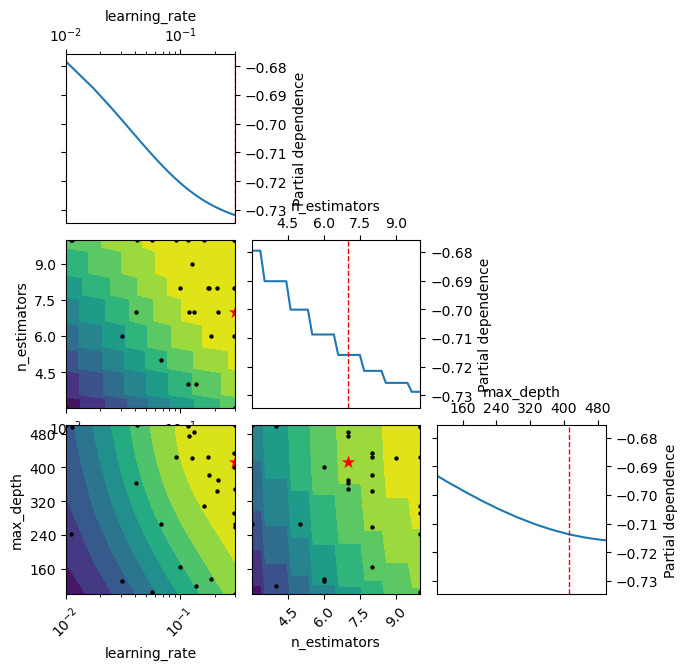

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["learning_rate", "n_estimators", "max_depth"])
plt.show()

## Modell erstellen

In [32]:
xgboost_model = pipe.fit(train_values, train_labels.values.ravel())


## Vorhersagen erstellen

In [33]:
val_preds = xgboost_model.predict(validation_values)
# F1-Score berechnen
print(f1_score(validation_labels, val_preds, average='micro'))


0.7448053567659868


## Feature Wichtigkeit

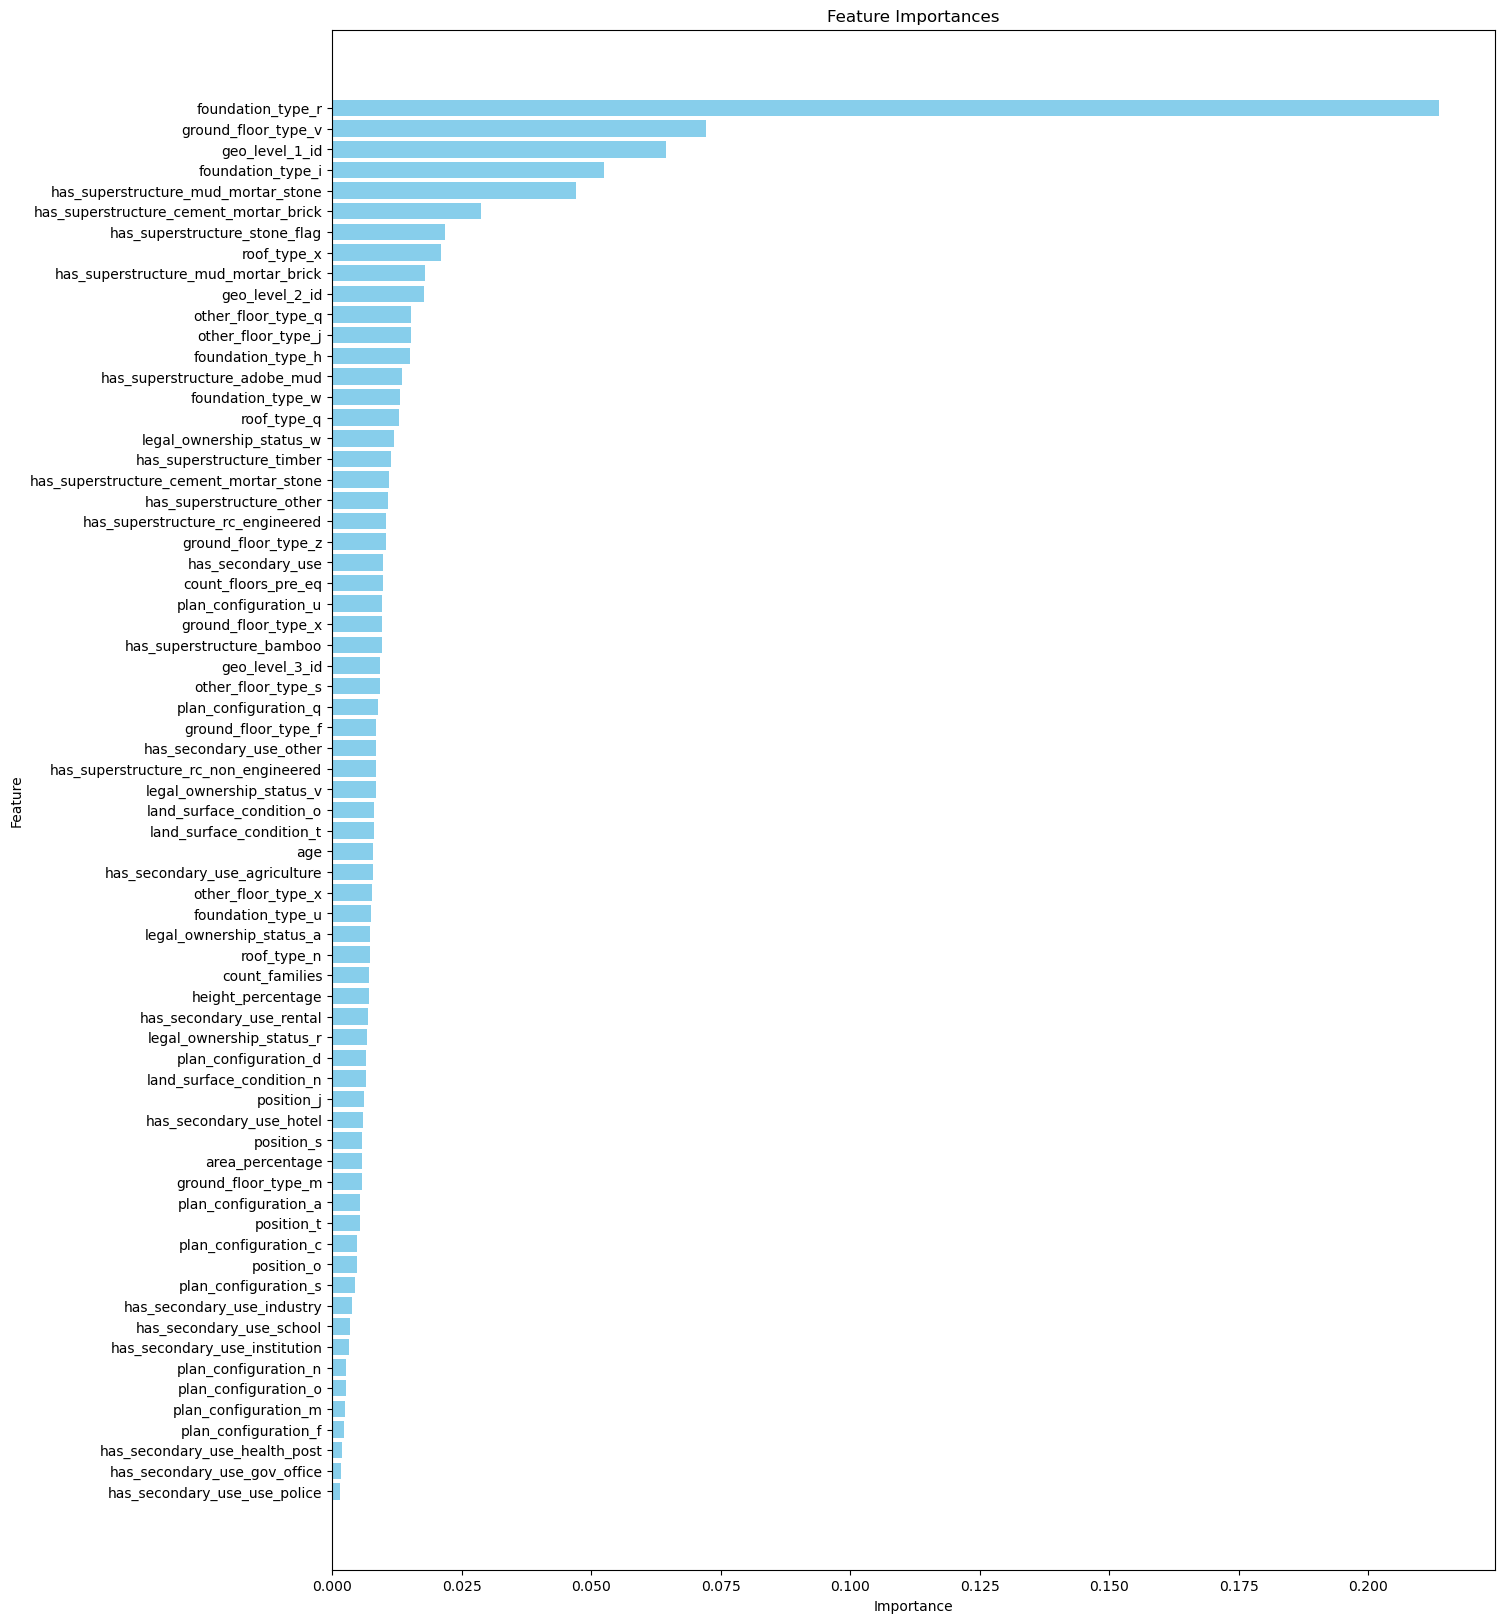

In [34]:
# Feature Wichtigkeiten
importances = xgboost_model.named_steps['xgbclassifier'].feature_importances_
features_df = pd.DataFrame({
    'Feature': train_values.columns,
    'Importance': importances
})
# Sortieren der Werte nach Wichtigkeit
features_df = features_df.sort_values('Importance', ascending=False)

# Erstellen des Plots
plt.figure(figsize=(15, 20))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben anzuzeigen
plt.show()

## Konfusionsmatrix erstellen

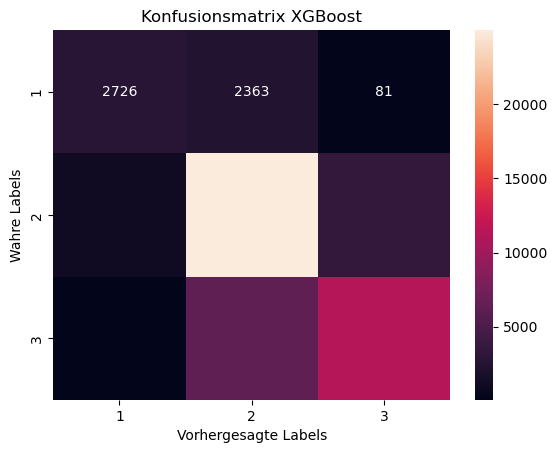

In [35]:
cm = confusion_matrix(validation_labels, val_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Konfusionsmatrix XGBoost')
plt.show()

## Submission erstellen

In [ ]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
test_values = pd.get_dummies(test_values)
predictions = opt.predict(test_values)
predictions = predictions + 1
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)   

my_submission.head()
my_submission.to_csv('submission_xgboost.csv')